In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
import arviz as az
import os
import pickle
import importlib.resources

tfd = tfp.distributions
tfb = tfp.bijectors

from bayesianquilts.model import BayesianModel
from bayesianquilts.vi.minibatch import minibatch_fit_surrogate_posterior
from bayesianquilts.metrics.ais import AdaptiveImportanceSampler
from bayesianquilts.predictors.regression.negbin import NegativeBinomialRegression
from bayesianquilts.predictors.regression.negbin import NegativeBinomialRegressionLikelihood

Patched _JointDistributionNamedSpec with _structure_with_callables=None
TFP Specs patched successfully.


In [2]:
# Load the dataset
try:
    data_path = str(importlib.resources.files('bayesianquilts.data').joinpath('roachdata.csv'))
except ImportError:
    # Fallback if package not installed
    data_path = '../../bayesianquilts/data/roachdata.csv'
    if not os.path.exists(data_path):
        data_path = 'bayesianquilts/data/roachdata.csv'

print(f'Loading data from {data_path}')
df = pd.read_csv(data_path)
print(df.head())

# Preprocessing
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

df['roach1'] = 0.01 * df['roach1']

# Target
y_data = df['y'].values

# Features
# Drop target and any index columns
X_df = df.drop(columns=['y'])
X_data = X_df.values.astype(np.float32)

# Normalize features
    # mean = X_data.mean(axis=0)
    # std = X_data.std(axis=0)
    # X_data = (X_data - mean) / std
    #print('Features NOT normalized')
y_data = y_data.astype(np.float32)

print(f'X shape: {X_data.shape}, y shape: {y_data.shape}')

Loading data from /Users/josh/workspace/bayesianquilts/bayesianquilts/data/roachdata.csv
   Unnamed: 0    y  roach1  treatment  senior  exposure2
0           1  153  308.00          1       0   0.800000
1           2  127  331.25          1       0   0.600000
2           3    7    1.67          1       0   1.000000
3           4    7    3.00          1       0   1.000000
4           5    0    2.00          1       0   1.142857
X shape: (262, 4), y shape: (262,)


In [3]:
# Instantiate GLM Negative Binomial Regression
# This is a standard GLM: log(mean) = X * beta + intercept

# First, check the scale of the outcome
print(f'Target variable (y) statistics:')
print(f'  Min: {y_data.min():.2f}')
print(f'  Max: {y_data.max():.2f}')
print(f'  Mean: {y_data.mean():.2f}')
print(f'  Std: {y_data.std():.2f}')
print(f'  Variance: {y_data.var():.2f}')
print(f'  Variance/Mean: {y_data.var() / y_data.mean():.2f}')
print(f'  Zeros: {(y_data == 0).sum()} / {len(y_data)} ({100*(y_data == 0).mean():.1f}%)')
if (y_data > 0).any():
    print(f'  y[y>0] mean: {y_data[y_data > 0].mean():.2f}')

# High variance/mean ratio suggests negative binomial is appropriate
var_mean_ratio = y_data.var() / y_data.mean()
if var_mean_ratio > 1:
    print(f'\n→ Overdispersed data (var/mean = {var_mean_ratio:.2f} > 1)')
    print('  Negative Binomial is more appropriate than Poisson!')

# Decide whether to use zero-inflation
zero_pct = 100 * (y_data == 0).mean()
use_zero_inflated = zero_pct > 20  # Heuristic: use ZI if >20% zeros

print(f'\nUsing zero-inflated model: {use_zero_inflated} ({zero_pct:.1f}% zeros)')

model = NegativeBinomialRegression(
    input_dim=X_data.shape[1],
    zero_inflated=use_zero_inflated,
    prior_scale_beta=10.0,
    prior_scale_intercept=10.0,
    dtype=jnp.float64
)

print(f'\nModel: NegativeBinomialRegression (GLM)')
if use_zero_inflated:
    print(f'  - Likelihood: Zero-Inflated Negative Binomial')
    print(f'  - Parameters: beta, intercept, log_concentration, zero_logit')
else:
    print(f'  - Likelihood: Negative Binomial')
    print(f'  - Parameters: beta, intercept, log_concentration')
print(f'  - Linear predictor: log(mean) = X @ beta + intercept')
print(f'  - Concentration: controls overdispersion')
print(f'  - Number of features: {X_data.shape[1]}')

# Data dictionary
data_dict = {'X': X_data, 'y': y_data}
data_jax = {'X': jnp.array(X_data), 'y': jnp.array(y_data)}

# Check init
print('\nChecking initialization...')
try:
    seed = jax.random.PRNGKey(42)
    # Test prior sample
    prior_params = model.surrogate_parameter_initializer(seed)
    print('Surrogate parameter keys:', prior_params.keys())
except Exception as e:
    print(f'Initialization failed: {e}')


Target variable (y) statistics:
  Min: 0.00
  Max: 357.00
  Mean: 25.65
  Std: 50.75
  Variance: 2575.50
  Variance/Mean: 100.41
  Zeros: 94 / 262 (35.9%)
  y[y>0] mean: 40.00

→ Overdispersed data (var/mean = 100.41 > 1)
  Negative Binomial is more appropriate than Poisson!

Using zero-inflated model: True (35.9% zeros)

Model: NegativeBinomialRegression (GLM)
  - Likelihood: Zero-Inflated Negative Binomial
  - Parameters: beta, intercept, log_concentration, zero_logit
  - Linear predictor: log(mean) = X @ beta + intercept
  - Concentration: controls overdispersion
  - Number of features: 4

Checking initialization...
Surrogate parameter keys: dict_keys(['beta_loc', 'beta_raw_scale', 'intercept_loc', 'intercept_raw_scale', 'log_concentration_loc', 'log_concentration_raw_scale', 'zero_logit_loc', 'zero_logit_raw_scale'])


In [4]:
# Fit using MCMC with Pathfinder initialization

print('='*70)
print('PATHFINDER INITIALIZATION STRATEGY (Conservative Settings)')
print('='*70)

import jax.flatten_util
import blackjax.vi.pathfinder as pathfinder

def pathfinder_initialization(model, data, num_chains=4, num_samples=200, maxiter=100, 
                              ftol=1e-6, gtol=1e-9, verbose=True):
    """
    Use Pathfinder variational inference to initialize MCMC chains.
    """
    if verbose:
        print('\nStep 1: Running Pathfinder variational inference...')
        print(f'  L-BFGS settings: ftol={ftol}, gtol={gtol} (conservative)')

    # Setup parameter flattening
    key = jax.random.PRNGKey(0)
    prior_sample = model.prior_distribution.sample(1, seed=key)
    template = {var: prior_sample[var][0] for var in model.var_list}

    flat_template, unflatten_fn = jax.flatten_util.ravel_pytree(template)
    param_dim = flat_template.shape[0]

    if verbose:
        print(f'  Parameter space dimension: {param_dim}')

    # Define log probability for Pathfinder
    def logprob_fn_flat(params_flat):
        params_dict = unflatten_fn(params_flat)
        return model.unormalized_log_prob(data=data, **params_dict)

    # Run Pathfinder with conservative tolerances
    initial_position = jax.random.normal(jax.random.PRNGKey(42), (param_dim,)) * 0.1

    state, info = pathfinder.approximate(
        rng_key=jax.random.PRNGKey(123),
        logdensity_fn=logprob_fn_flat,
        initial_position=initial_position,
        num_samples=num_samples,
        maxiter=maxiter,
        ftol=ftol,
        gtol=gtol,
    )

    if verbose:
        print(f'  ✓ Pathfinder converged! ELBO: {float(state.elbo):.3f}')

    # Sample diverse initial states
    if verbose:
        print(f'\nStep 2: Sampling {num_chains} diverse initial states...')

    sample_key = jax.random.PRNGKey(456)
    samples_result = pathfinder.sample(sample_key, state, num_samples=num_chains)
    samples_flat = samples_result[0] if isinstance(samples_result, tuple) else samples_result

    if verbose:
        print(f'  ✓ Sampled from approximate posterior')

    # Unflatten and organize by parameter
    chain_inits = {var: [] for var in model.var_list}

    for i in range(num_chains):
        sample_dict = unflatten_fn(samples_flat[i])
        for var_name in model.var_list:
            chain_inits[var_name].append(sample_dict[var_name])

    # Stack into (num_chains, ...) format
    for var_name in model.var_list:
        chain_inits[var_name] = jnp.stack(chain_inits[var_name], axis=0)

    if verbose:
        print('  ✓ Initial states ready for MCMC')

    return chain_inits

def check_rhat(model, threshold=1.05):
    """Check R-hat convergence with strict threshold."""
    import tensorflow_probability.substrates.jax.mcmc as tfmcmc
    print("\nChecking R-hat convergence...")
    all_good = True
    max_rhat_overall = 0.0

    for var, samples in model.mcmc_samples.items():
        samples_transposed = jnp.swapaxes(samples, 0, 1)
        rhat = tfmcmc.potential_scale_reduction(samples_transposed)
        rhat = jnp.where(jnp.isnan(rhat), 1.0, rhat)
        max_r = float(jnp.max(rhat))
        mean_r = float(jnp.mean(rhat))
        max_rhat_overall = max(max_rhat_overall, max_r)

        if max_r > threshold:
            all_good = False
            print(f"  ✗ {var:20s}: max R-hat {max_r:.3f} (mean {mean_r:.3f}) > {threshold}")
        else:
            print(f"  ✓ {var:20s}: max R-hat {max_r:.3f} (mean {mean_r:.3f})")

    print(f"\nOverall max R-hat: {max_rhat_overall:.3f}")

    if all_good:
        print(f"✓ EXCELLENT: All R-hat < {threshold}!")
    else:
        print(f"✗ Convergence not achieved.")
    return all_good

def check_rhat_and_save(model, cache_dir, threshold=1.05):
    """Check R-hat convergence and save model."""
    all_good = check_rhat(model, threshold)
    if all_good:
        print(f"Saving model to {cache_dir}...")
        model.save_to_disk(cache_dir)
        return True
    else:
        print(f"Model NOT saved.")
        print(f"  Recommendation: Increase num_warmup to 15000-20000")
        return False

# Main fitting logic with Pathfinder
cache_suffix = 'zinb' if use_zero_inflated else 'nb'
cache_dir = f'/tmp/negbin_glm_{cache_suffix}'

if os.path.exists(os.path.join(cache_dir, 'config.yaml')):
    print(f"\nLoading fitted model from {cache_dir}...")
    try:
        model = NegativeBinomialRegression.load_from_disk(cache_dir)
        print("✓ Model loaded from cache!")
    except Exception as e:
        print(f"✗ Failed to load model: {e}")
        print("  Will refit with Pathfinder...")
        
        chain_inits = pathfinder_initialization(
            model, data_dict, 
            num_chains=4, 
            num_samples=200,
            maxiter=100,
            ftol=1e-6,
            gtol=1e-9
        )
        
        print('\nStep 3: Running MCMC with Pathfinder initialization...')
        try:
            model.fit_mcmc(
                data=data_dict,
                num_samples=2000,
                num_warmup=15000,
                num_chains=4,
                target_accept_prob=0.95,
                step_size=1e-3,
                initial_states=chain_inits
            )
            print("✓ MCMC Complete.")
            check_rhat_and_save(model, cache_dir, threshold=1.05)
        except Exception as e:
            print(f"✗ MCMC failed: {e}")
else:
    print('\nNo cached model found. Starting fresh fit with Pathfinder...')
    
    chain_inits = pathfinder_initialization(
        model, data_dict,
        num_chains=4,
        num_samples=200,
        maxiter=100,
        ftol=1e-6,
        gtol=1e-9
    )
    
    print('\nStep 3: Running MCMC with Pathfinder-initialized chains...')
    try:
        model.fit_mcmc(
            data=data_dict,
            num_samples=2000,
            num_warmup=15000,
            num_chains=4,
            target_accept_prob=0.95,
            step_size=1e-3,
            initial_states=chain_inits
        )
        print("✓ MCMC Complete.")
        
        converged = check_rhat_and_save(model, cache_dir, threshold=1.05)
        
        if not converged:
            print("\n" + "!"*70)
            print("WARNING: Chains did not fully converge!")
            print("\nRecommendations:")
            print("  1. Increase num_warmup to 15000-20000")
            print("  2. Run more chains (6-8) for better mixing")
            print("  3. Try higher target_accept_prob (0.90-0.95)")
            print("!"*70)
        
    except Exception as e:
        print(f"✗ MCMC failed: {e}")

print('\n' + '='*70)
print('FITTING COMPLETE')
print('='*70)
model_type = 'Zero-Inflated ' if use_zero_inflated else ''
print(f'\nPathfinder + NUTS MCMC Summary ({model_type}Negative Binomial GLM):')
print(f'  - Model: GLM with {model_type.lower()}negative binomial likelihood')
print(f'  - Linear predictor: log(mean) = X @ beta + intercept')
print(f'  - Parameters: beta ({X_data.shape[1]}), intercept (1), log_concentration (1)', end='')
if use_zero_inflated:
    print(', zero_logit (1)')
else:
    print()
print('  - Pathfinder L-BFGS: ftol=1e-6, gtol=1e-9 (conservative)')
print('  - MCMC: 4 chains × 2000 samples with 15000 warmup')
print('  - MCMC step size: 1e-4 (conservative, will adapt during warmup)')
print('='*70)

check_rhat(model)


PATHFINDER INITIALIZATION STRATEGY (Conservative Settings)

Loading fitted model from /tmp/negbin_glm_zinb...
✓ Model loaded from cache!

FITTING COMPLETE

Pathfinder + NUTS MCMC Summary (Zero-Inflated Negative Binomial GLM):
  - Model: GLM with zero-inflated negative binomial likelihood
  - Linear predictor: log(mean) = X @ beta + intercept
  - Parameters: beta (4), intercept (1), log_concentration (1), zero_logit (1)
  - Pathfinder L-BFGS: ftol=1e-6, gtol=1e-9 (conservative)
  - MCMC: 4 chains × 2000 samples with 15000 warmup
  - MCMC step size: 1e-4 (conservative, will adapt during warmup)

Checking R-hat convergence...
  ✓ beta                : max R-hat 1.001 (mean 1.000)
  ✓ intercept           : max R-hat 1.000 (mean 1.000)
  ✓ log_concentration   : max R-hat 1.001 (mean 1.001)
  ✓ zero_logit          : max R-hat 1.002 (mean 1.002)

Overall max R-hat: 1.002
✓ EXCELLENT: All R-hat < 1.05!


True

In [5]:
# Examine posterior estimates

print('='*70)
print('POSTERIOR ESTIMATES')
print('='*70)

# Get posterior samples
beta_samples = model.mcmc_samples['beta']
intercept_samples = model.mcmc_samples['intercept']
log_concentration_samples = model.mcmc_samples['log_concentration']

print(f'\nRegression Coefficients (beta):')
print(f'  Shape: {beta_samples.shape}')
for i, feature in enumerate(X_df.columns):
    mean_val = beta_samples[..., i].mean()
    std_val = beta_samples[..., i].std()
    q025 = jnp.percentile(beta_samples[..., i], 2.5)
    q975 = jnp.percentile(beta_samples[..., i], 97.5)
    print(f'  {feature:15s}: {mean_val:7.3f} ± {std_val:.3f}  [{q025:.3f}, {q975:.3f}]')

print(f'\nIntercept:')
mean_int = intercept_samples.mean()
std_int = intercept_samples.std()
q025_int = jnp.percentile(intercept_samples, 2.5)
q975_int = jnp.percentile(intercept_samples, 97.5)
print(f'  {mean_int:.3f} ± {std_int:.3f}  [{q025_int:.3f}, {q975_int:.3f}]')

print(f'\nConcentration (overdispersion):')
concentration_samples = jnp.exp(log_concentration_samples)
mean_conc = concentration_samples.mean()
std_conc = concentration_samples.std()
q025_conc = jnp.percentile(concentration_samples, 2.5)
q975_conc = jnp.percentile(concentration_samples, 97.5)
print(f'  {mean_conc:.3f} ± {std_conc:.3f}  [{q025_conc:.3f}, {q975_conc:.3f}]')
print(f'  (Higher concentration = less overdispersion)')

if model.zero_inflated:
    zero_logit_samples = model.mcmc_samples['zero_logit']
    zero_prob_samples = jax.nn.sigmoid(zero_logit_samples)
    mean_zero = zero_prob_samples.mean()
    std_zero = zero_prob_samples.std()
    q025_zero = jnp.percentile(zero_prob_samples, 2.5)
    q975_zero = jnp.percentile(zero_prob_samples, 97.5)
    print(f'\nZero-Inflation Probability:')
    print(f'  {mean_zero:.3f} ± {std_zero:.3f}  [{q025_zero:.3f}, {q975_zero:.3f}]')
    print(f'  (Observed zeros: {100*(y_data==0).mean():.1f}%)')

print('\n' + '='*70)

POSTERIOR ESTIMATES

Regression Coefficients (beta):
  Shape: (4, 2000, 4)
  roach1         :  -0.012 ± 0.002  [-0.018, -0.008]
  treatment      :   0.754 ± 0.246  [0.281, 1.246]
  senior         :   0.306 ± 0.271  [-0.243, 0.827]
  exposure2      :  -0.606 ± 0.625  [-1.957, 0.473]

Intercept:
  -4.729 ± 0.699  [-6.023, -3.293]

Concentration (overdispersion):
  0.302 ± 0.043  [0.236, 0.404]
  (Higher concentration = less overdispersion)

Zero-Inflation Probability:
  0.063 ± 0.047  [0.005, 0.181]
  (Observed zeros: 35.9%)



PREDICTIVE CHECKS

Posterior Predictive Summary:
  Observed mean: 25.65
  Predicted mean: 0.01
  Observed std: 50.75
  Predicted std: 0.01


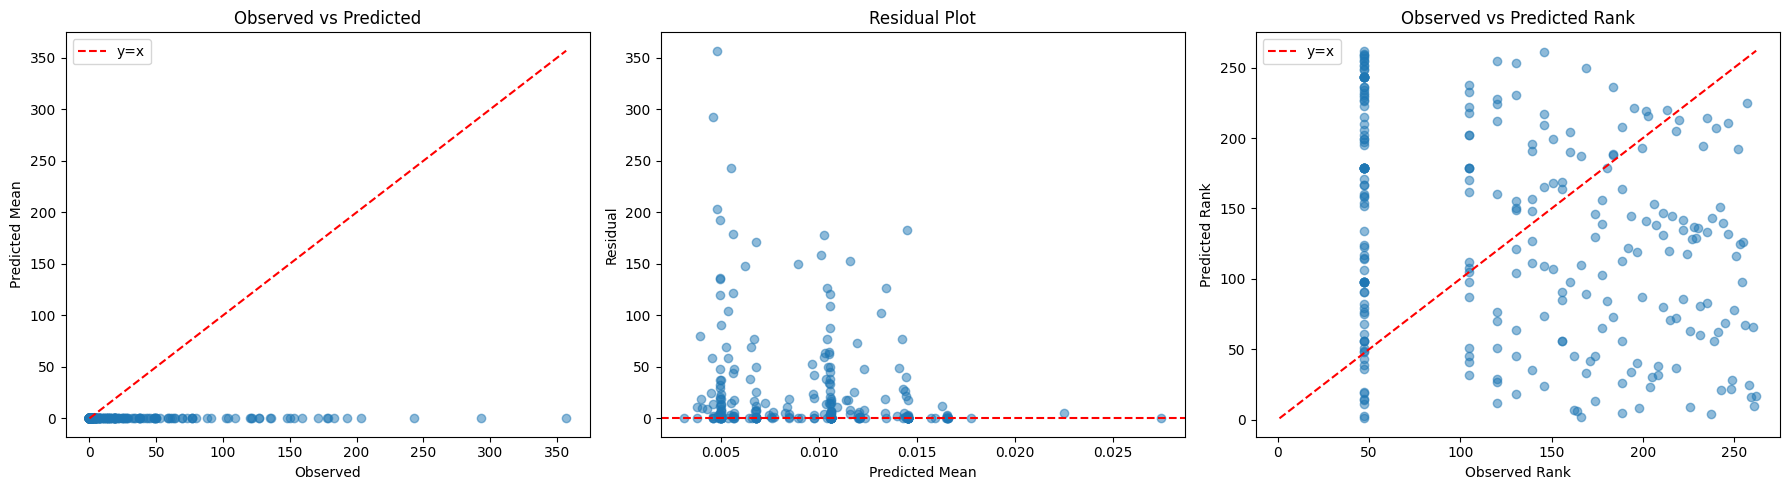

: 

In [ ]:
# Predictive checks

print('='*70)
print('PREDICTIVE CHECKS')
print('='*70)

# Sample posterior predictive
n_posterior_samples = min(500, beta_samples.shape[0] * beta_samples.shape[1])
flat_beta = beta_samples.reshape(-1, beta_samples.shape[-1])
flat_intercept = intercept_samples.reshape(-1, intercept_samples.shape[-1])
flat_log_conc = log_concentration_samples.reshape(-1, log_concentration_samples.shape[-1])

# Sample indices
sample_idx = jax.random.choice(jax.random.PRNGKey(123), flat_beta.shape[0], 
                              shape=(n_posterior_samples,), replace=False)

# Get predictions
pred_means = []
for idx in sample_idx:
    params = {
        'beta': flat_beta[idx],
        'intercept': flat_intercept[idx],
        'log_concentration': flat_log_conc[idx]
    }
    if model.zero_inflated:
        flat_zero_logit = model.mcmc_samples['zero_logit'].reshape(-1, 1)
        params['zero_logit'] = flat_zero_logit[idx]
    
    pred_dist = model.predictive_distribution(data_dict, **params)
    pred_means.append(pred_dist['mean'])

pred_means = jnp.array(pred_means)

# Compute summaries
pred_mean = pred_means.mean(axis=0)
pred_lower = jnp.percentile(pred_means, 2.5, axis=0)
pred_upper = jnp.percentile(pred_means, 97.5, axis=0)

print(f'\nPosterior Predictive Summary:')
print(f'  Observed mean: {y_data.mean():.2f}')
print(f'  Predicted mean: {pred_mean.mean():.2f}')
print(f'  Observed std: {y_data.std():.2f}')
print(f'  Predicted std: {pred_means.std():.2f}')

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Observed vs Predicted
axes[0].scatter(y_data, pred_mean, alpha=0.5)
axes[0].plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'r--', label='y=x')
axes[0].set_xlabel('Observed')
axes[0].set_ylabel('Predicted Mean')
axes[0].set_title('Observed vs Predicted')
axes[0].legend()

# Residuals
residuals = y_data - pred_mean
axes[1].scatter(pred_mean, residuals, alpha=0.5)
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Mean')
axes[1].set_ylabel('Residual')
axes[1].set_title('Residual Plot')


# Observed vs Predicted Rank
obs_rank = pd.Series(y_data.flatten()).rank(method='average')
pred_rank = pd.Series(pred_mean).rank(method='average')
axes[2].scatter(obs_rank, pred_rank, alpha=0.5)
axes[2].plot([min(obs_rank.min(), pred_rank.min()), max(obs_rank.max(), pred_rank.max())], 
                [min(obs_rank.min(), pred_rank.min()), max(obs_rank.max(), pred_rank.max())], 'r--', label='y=x')
axes[2].set_xlabel('Observed Rank')
axes[2].set_ylabel('Predicted Rank')
axes[2].set_title('Observed vs Predicted Rank')
axes[2].legend()

plt.tight_layout()
plt.show()

print('\n' + '='*70)

In [7]:
# AIS LOO-CV Simulation
import pandas as pd
from tqdm.auto import tqdm
import copy
import gc

# Initialize Likelihood and Sampler
likelihood_fn = NegativeBinomialRegressionLikelihood(model)
ais_sampler = AdaptiveImportanceSampler(likelihood_fn=likelihood_fn)

n_simulations = 100
n_samples = 1000
rhos = [ 3**-r for r in range(1, 8) ]

# Split transformations
base_transform = ['identity']
other_transforms = ['ll', 'kl', 'var', 'mm1', 'mm2', 'pmm1', 'pmm2']

model_type_str = 'ZINB' if model.zero_inflated else 'NB'
print(f"Running {n_simulations} simulations with s={n_samples} samples per run.")
print(f"Using {model_type_str} GLM likelihood")
print(f"Rhos: {rhos}")
print(f"Base Transform: {base_transform}")
print(f"Other Transforms: {other_transforms}")

N_obs = data_jax['y'].shape[0]

simulation_records = []

for i in tqdm(range(n_simulations), desc="Simulations"):
    # 1. Sample Parameters
    params = model.sample_mcmc(num_samples=n_samples)

    # 2. Run AIS with Identity FIRST
    results_base = ais_sampler.adaptive_is_loo(
        data=data_jax,
        params=params,
        rhos=rhos,
        variational=False,
        transformations=base_transform
    )

    khat_identity = np.array(results_base['identity']['khat'])
    idx_bad = np.where(khat_identity >= 0.7)[0]

    print(f"Sim {i+1}: Found {len(idx_bad)} / {N_obs} data points needing adaptation.")

    del results_base
    gc.collect()

    # Prepare storage
    method_khats = {}
    method_khats['identity'] = khat_identity
    for m in other_transforms:
        method_khats[m] = np.array(khat_identity.copy())

    # 3. Process problematic points
    if len(idx_bad) > 0:
        batch_size = 4
        num_batches = int(np.ceil(len(idx_bad) / batch_size))

        for b in range(num_batches):
            batch_idx = idx_bad[b*batch_size : (b+1)*batch_size]
            data_subset = {
                'X': data_jax['X'][batch_idx],
                'y': data_jax['y'][batch_idx]
            }

            results_subset = ais_sampler.adaptive_is_loo(
                data=data_subset,
                params=params,
                rhos=rhos,
                variational=False,
                transformations=other_transforms
            )

            for base_method in other_transforms:
                khat_arrays = []
                for key, res in results_subset.items():
                    if key == 'best': continue
                    if key == base_method or key.startswith(base_method + '_'):
                        khat_arrays.append(res['khat'])

                if khat_arrays:
                    min_khat_subset = np.array(np.min(np.stack(khat_arrays), axis=0))
                    method_khats[base_method][batch_idx] = min_khat_subset

            del results_subset
            gc.collect()

    # Define Groups
    groups = {
        'Base': ['identity'],
        'PMM1': ['pmm1'],
        'PMM2': ['pmm2'],
        'KL': ['kl'],
        'Var': ['var'],
        'Ours_Combined': ['pmm1', 'pmm2', 'kl', 'var'],
        'LL': ['ll'],
        'MM1': ['mm1'],
        'MM2': ['mm2'],
        'Full': other_transforms + base_transform
    }

    sim_counts = {}
    for group_name, methods in groups.items():
        grouped_khats = []
        for m in methods:
             if m in method_khats:
                 grouped_khats.append(method_khats[m])

        if grouped_khats:
            best_group_khat = np.min(np.stack(grouped_khats), axis=0)
            n_failures = np.sum(best_group_khat > 0.7)
            sim_counts[group_name] = n_failures
        else:
            sim_counts[group_name] = np.nan

    simulation_records.append(sim_counts)

# 4. Aggregate Statistics
df_sims = pd.DataFrame(simulation_records)
stats = df_sims.agg(['mean', 'std'])

print(f"\n--- Table Metrics: Unsuccessful Adaptations (Roaches/{model_type_str} GLM) ---")
print(stats.round(1))

print("\nLaTeX Format (Mean ± Std):")
for col in df_sims.columns:
    m = stats.loc['mean', col]
    s = stats.loc['std', col]
    print(f"{col}: {m:.1f} ± {s:.1f}")

Running 100 simulations with s=1000 samples per run.
Using ZINB GLM likelihood
Rhos: [0.3333333333333333, 0.1111111111111111, 0.037037037037037035, 0.012345679012345678, 0.00411522633744856, 0.0013717421124828531, 0.0004572473708276177]
Base Transform: ['identity']
Other Transforms: ['ll', 'kl', 'var', 'mm1', 'mm2', 'pmm1', 'pmm2']


Simulations:   0%|          | 0/100 [00:00<?, ?it/s]

: 

: 

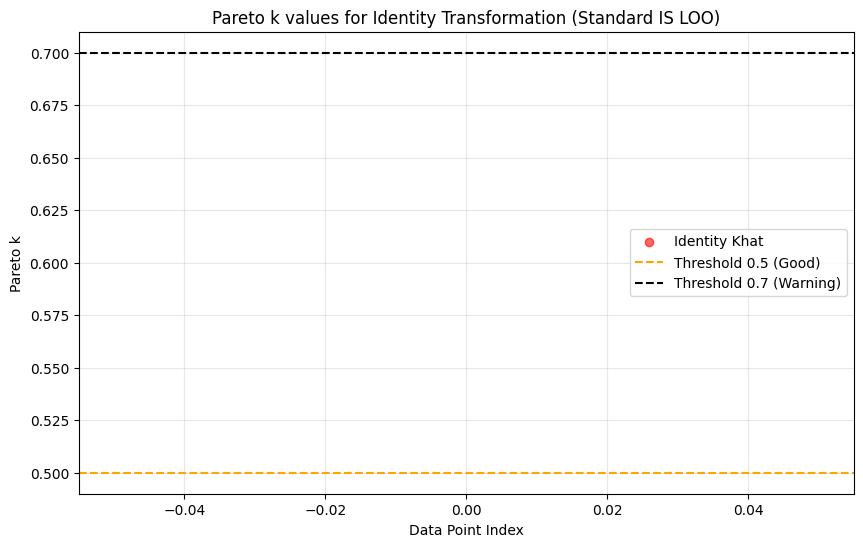

In [ ]:
# Plot khat values for identity transformation
plt.figure(figsize=(10, 6))
plt.scatter(range(len(method_khats['identity'])), method_khats['identity'], c='red', alpha=0.6, label='Identity Khat')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Threshold 0.5 (Good)')
plt.axhline(y=0.7, color='black', linestyle='--', label='Threshold 0.7 (Warning)')
plt.xlabel('Data Point Index')
plt.ylabel('Pareto k')
plt.title('Pareto k values for Identity Transformation (Standard IS LOO)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
